In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use("QtAgg")
import potrace
from skimage.morphology import thin
import cv2
from scipy.fft import fft, fftfreq
from matplotlib.animation import FuncAnimation

img_path = "/Users/askborgen/Desktop/code/website/desmosArt/images/pikachu.jpeg"
binCutoff = 121
thinSteps = 6
plotprocess = True
nSample = 1500
num_frames = 1500
num_harmonics = 500

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def img_to_outline(filepath):
    """image processing
    1) Load grayscale image
    2) Convert to binary array
    3) Skeletal thin
    4) Gaussian blur
    5) Canny edge detection
    """
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    binImg = np.array(img)
    binImg[binImg < binCutoff] = 1
    binImg[binImg > 1] = 0

    thinImg = thin(binImg, thinSteps)
    temp = np.zeros(thinImg.shape, dtype=np.uint8) # convert from binary array to 0-255 values
    temp[thinImg] = 255
    blurredImg = cv2.GaussianBlur(temp, (5,5), 1.4)
    edges = cv2.Canny(blurredImg, 50, 150)

    if plotprocess:
        fig, ((ax_orig, ax_bin, ax_thin), (ax_blur, ax_edge, _)) = plt.subplots(2, 3, figsize=(6, 15))
        ax_orig.imshow(img, cmap="gray")
        ax_bin.imshow(binImg, cmap="gray")
        ax_thin.imshow(thinImg, cmap="gray")
        ax_blur.imshow(blurredImg, cmap="gray")
        ax_edge.imshow(edges, cmap="gray")
        ax_orig.set_axis_off()
        ax_bin.set_axis_off()
        ax_thin.set_axis_off()
        ax_blur.set_axis_off()
        ax_edge.set_axis_off()
        fig.show()
        plt.show()
    return edges, _

def img_to_svg(filepath):
    data = np.abs(img_to_outline(filepath))
    bmp = potrace.Bitmap(data)
    path = bmp.trace()
    return path

def potrace_to_array(path: potrace.Path):
    points = []
    for curve in path:
        start = curve.start_point
        for segment in curve:
            if segment.is_corner:
                points.append([(start.x, start.y),
                               (segment.c.x, segment.c.y),
                               (segment.end_point.x, segment.end_point.y)])
            else:
                points.append([(start.x, start.y),
                               (segment.c1.x, segment.c1.y),
                               (segment.c2.x, segment.c2.y),
                               (segment.end_point.x, segment.end_point.y)])
            start = segment.end_point
    return points

In [3]:
def bezier(t, control_points):
    """Evaluate a Bézier curve at parameter t using De Casteljau's algorithm."""
    n = len(control_points) - 1
    points = np.array(control_points)
    for r in range(1, n + 1):
        points[:n - r + 1] = (1 - t) * points[:n - r + 1] + t * points[1:n - r + 2]
    return points[0]

def approx_arc_lenght(control_points, num_samples = 100):
    t_vals = np.linspace(0,1, num_samples)
    points = np.array([bezier(t, control_points) for t in t_vals])
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    return np.cumsum(distances), points

def sample_path(path, num_samples = nSample):
    # compute total arc lenght
    curve_lenghts = []
    curve_cumulative_lenghts = [0]
    for bezier in path:
        arc_lenghts, _ = approx_arc_lenght(bezier)
        curve_lenghts.append(arc_lenghts[-1])
        curve_cumulative_lenghts.append(curve_cumulative_lenghts[-1] + arc_lenghts[-1])

    total_lenght = curve_cumulative_lenghts[-1]
    even_lenghts = np.linspace(0, total_lenght, num_samples)

    # Map global lenght to bezier curves
    sampled_points = []
    for target_lenght in even_lenghts[1:]:
        curve_idx = np.searchsorted(curve_cumulative_lenghts, target_lenght) - 1
        length_within_curve = target_lenght - curve_cumulative_lenghts[curve_idx]

        control_points = path[curve_idx]
        arc_lenghts, curve_points = approx_arc_lenght(control_points)

        idx = np.searchsorted(arc_lenghts, length_within_curve)-1
        t_low, t_high = arc_lenghts[idx - 1], arc_lenghts[idx]
        point_low, point_high = curve_points[idx-1], curve_points[idx]
        alpha = (length_within_curve - t_low) / (t_high - t_low)
        sampled_point = (1 - alpha) * point_low + alpha * point_high

        sampled_points.append(sampled_point)
    
    return sampled_points

/var/folders/cb/_0w2qp3577j4gnzrgzsjrv4r0000gn/T/ipykernel_77804/4185417286.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


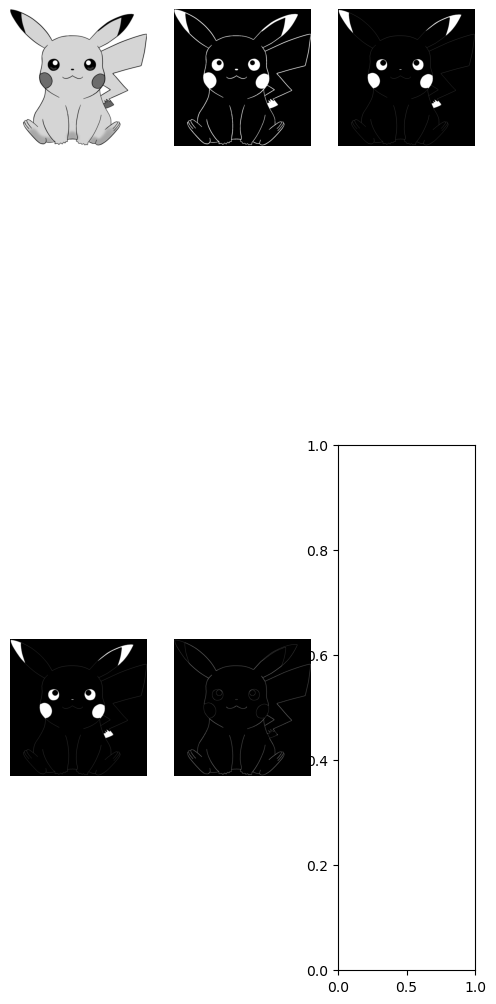

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [4]:
path = potrace_to_array(sorted(img_to_svg(img_path), key=len, reverse=True)[:1])
points = sample_path(path)
points = np.vstack(points) / cv2.imread(img_path).shape[0]
points[:,1]*=-1

In [ ]:
%matplotlib inline
t = np.linspace(0, 2 * np.pi, len(points))
x = points[:, 0]
y = points[:, 1]

# Create a complex signal
z = x + 1j * y

colors = np.arrange(len(x))
plt.scatter(x,y, c=colors, cmap="viridis")

2024-11-28 08:46:07.673 python[55624:839052] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-28 08:46:07.673 python[55624:839052] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


2024-11-28 12:45:19.503 python[77155:1054411] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-28 12:45:19.504 python[77155:1054411] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [ ]:
%matplotlib qt6
def harmonic_circles(points, num_harmonics=num_harmonics, num_frames=num_frames):
    """Visualize Fourier Series Harmonic Circles for a list of points."""
    points = np.array(points, dtype=complex)
    n = len(points)
    fourier_coeffs = fft(points) / n

    # Sort coefficients by magnitude
    harmonics = sorted(
        ((np.abs(c), k, c) for k, c in zip(fftfreq(len(fourier_coeffs))*n, fourier_coeffs)),
        key=lambda x: x[0],
        reverse=True
    )[:num_harmonics]

    # Generate the animation
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.set_xlim(points.real.min() - 1, points.real.max() + 1)
    ax.set_ylim(points.imag.min() - 1, points.imag.max() + 1)
    
    circle_lines = [plt.Circle((0, 0), radius=0, fill=False, color="gray") for _ in harmonics]
    for circle in circle_lines:
        ax.add_artist(circle)
    trajectory_line, = ax.plot([], [], 'r-', lw=1)
    #points_scatter = ax.scatter(points.real, points.imag, s=5, c='blue')

    trajectory = []

    def update(frame):
        nonlocal trajectory
        x, y = 0, 0
        for i, (radius, freq, coeff) in enumerate(harmonics):
            phase = np.angle(coeff)
            x += radius * np.cos(2 * np.pi * freq * frame / num_frames + phase)
            y += radius * np.sin(2 * np.pi * freq * frame / num_frames + phase)
            circle_lines[i].center = (x, y)
            circle_lines[i].radius = radius

        trajectory.append((x, y))
        trajectory = trajectory[-n:]
        trajectory_line.set_data(*zip(*trajectory))

        return trajectory_line, *circle_lines

    ani = FuncAnimation(fig, update, frames=num_frames, interval=20, blit=True)
    #%matplotlib qt6
    plt.show()

In [ ]:
%matplotlib qt6
harmonic_circles(z)
plt.show()

: 